# Распознавание эмоций человека
[Skillbox. Дипломная работа по компьютерному зрению](https://www.kaggle.com/c/skillbox-computer-vision-project/)

In [ ]:
# Структура папок

# BASE_PATH/
# ├─ dataset/                 # Содержит изображения
# │  ├─ test_kaggle/          # тестовые изображения
# │  └─ train/                # изображения для обучения
# │     ├─ {эмоция_1}/
# │     ├─ {эмоция_2}/
# │     └─ ...
# └─ zip/                     # Скачанные архивы
# └─ text_files/              # Всякие *.csv
# └─ exported_models/         # Готовые модели

In [ ]:
# Распаковываем данные. Нужно сделать 1 раз.
# !unzip /content/drive/MyDrive/hackathons/cv_emotions/zip/test_kaggle.zip -d /content/drive/MyDrive/hackathons/cv_emotions/dataset
# !unzip /content/drive/MyDrive/hackathons/cv_emotions/zip/train.zip -d /content/drive/MyDrive/hackathons/cv_emotions/dataset
# !unzip /content/drive/MyDrive/hackathons/cv_emotions/zip/train.csv.zip -d /content/drive/MyDrive/hackathons/cv_emotions/text_files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import time
from os import listdir
import numpy as np

In [ ]:
BASE_PATH = '/content/drive/MyDrive/hackathons/cv_emotions'
TRAIN_FOLDER = BASE_PATH + '/dataset/train'
EXP_MODELS = BASE_PATH + '/exported_models'
TO_PREDICT_FOLDER = BASE_PATH + '/dataset/test_kaggle/'

BATCH_SIZE = 100
IMG_SIZE = (224, 224)

In [ ]:
def decode_img(file_path: str, img_height: int, img_width: int):
  '''
  Из линка картинки получаем tf

  :param file_path: линк к файлу str
  :param img_width: ширина картинки int
  :param img_height: высота картинки int
  :return: тензор с картинкой для tensorflow
  '''
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [img_height, img_width])

# Запуск готовой модели через функцию

In [ ]:
def predict_emotions(pics_folder, model_link, warmup = True):
  '''
  Загружаем модель из .h5 файла, предсказываем классы
  
  :param pics_folder: ссылка на папку с фотографиями
  :param model_link: ссылка на модель .h5
  :param warmup: кладем картинки в доступное для Google Colab место. 
                 Поставить False не на Google Colab
  '''
  # Имена классов
  class_names =['anger',
                'contempt',
                'disgust',
                'fear',
                'happy',
                'neutral',
                'sad',
                'surprise',
                'uncertain']

  start_time = time.time()

  

  # Загружаем модель
  model = tf.keras.models.load_model(model_link)
  model.trainable = False

  # Если модель, сначала погреть, потом она начинает работать в разы быстрее
  # По крайней мере, у меня так выходило на Google Colab
  if warmup==True:
    print('Прогрев начат')
    !rm -rf /content/drive/MyDrive/hackathons/cv_emotions/dataset/test_kaggle/
    !unzip /content/drive/MyDrive/hackathons/cv_emotions/zip/test_kaggle.zip -d /content/drive/MyDrive/hackathons/cv_emotions/dataset
    print('Прогрев закончен')
  
  img_names = []
  class_names_list = []

  
  for filename in tqdm(listdir(pics_folder)):
    link = TO_PREDICT_FOLDER + filename
    i = np.argmax(model.predict(decode_img(link, IMG_SIZE[0], IMG_SIZE[1])[None,:,:,:]))
    class_names_list.append(class_names[i])
    img_names.append(filename)
  end_time = time.time()
  print('Время на инференс одной картинки: {:.2f}'.format((end_time - start_time)/len(listdir(TO_PREDICT_FOLDER))))
  
  df_result = pd.DataFrame(zip(img_names, class_names_list), columns = ['image_path', 'emotion'])
  
  return df_result

In [ ]:
# df_result_f = predict_emotions(TO_PREDICT_FOLDER, EXP_MODELS + '/resnet_finetuned.h5')

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/drive/MyDrive/hackathons/cv_emotions/dataset/test_kaggle/0.jpg  
  inflating: /content/drive/MyDrive/hackathons/cv_emotions/dataset/test_kaggle/1.jpg  
  inflating: /content/drive/MyDrive/hackathons/cv_emotions/dataset/test_kaggle/10.jpg  
  inflating: /content/drive/MyDrive/hackathons/cv_emotions/dataset/test_kaggle/100.jpg  
  inflating: /content/drive/MyDrive/hackathons/cv_emotions/dataset/test_kaggle/1000.jpg  
  inflating: /content/drive/MyDrive/hackathons/cv_emotions/dataset/test_kaggle/1001.jpg  
  inflating: /content/drive/MyDrive/hackathons/cv_emotions/dataset/test_kaggle/1002.jpg  
  inflating: /content/drive/MyDrive/hackathons/cv_emotions/dataset/test_kaggle/1003.jpg  
  inflating: /content/drive/MyDrive/hackathons/cv_emotions/dataset/test_kaggle/1004.jpg  
  inflating: /content/drive/MyDrive/hackathons/cv_emotions/dataset/test_kaggle/1005.jpg  
  inflating: /content/drive/MyDrive/hacka

  0%|          | 0/5000 [00:00<?, ?it/s]

Прогрев закончен


100%|██████████| 5000/5000 [03:51<00:00, 21.63it/s]


Время на инференс одной картинки: 0.06


Посмотрим на данные, которые у нас есть

# Изучение данных

In [ ]:
df_train = pd.read_csv(BASE_PATH + '/text_files/train.csv')
df_train = df_train[['image_path', 'emotion']]
df_train.head()

,image_path,emotion
0,./train/anger/0.jpg,anger
1,./train/anger/1.jpg,anger
2,./train/anger/10.jpg,anger
3,./train/anger/100.jpg,anger
4,./train/anger/1000.jpg,anger


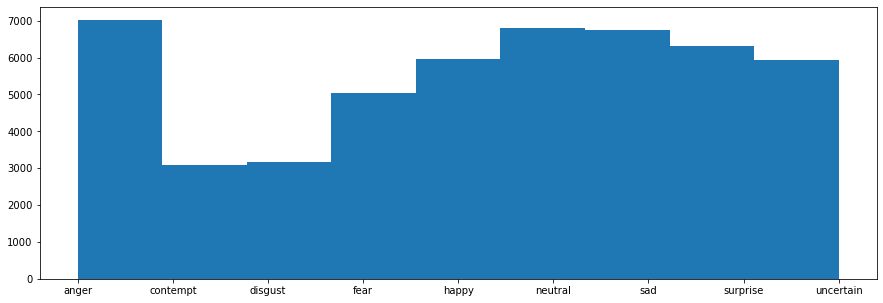

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(df_train.emotion,
         bins = len(df_train.emotion.unique()),
         align='mid')
plt.show()

In [ ]:
df_train_group = df_train[['emotion']].groupby(['emotion']).agg({'emotion':'count'}).rename(columns={'emotion':'img_number'}).reset_index()

In [ ]:
df_train_group['img_num_share'] = df_train_group['img_number']/df_train.shape[0]

In [ ]:
df_train_group

,emotion,img_number,img_num_share
0,anger,7022,0.140311
1,contempt,3085,0.061643
2,disgust,3155,0.063042
3,fear,5044,0.100787
4,happy,5955,0.118991
5,neutral,6795,0.135775
6,sad,6740,0.134676
7,surprise,6323,0.126344
8,uncertain,5927,0.118431


Мы видим, что меньше всего эмоций contempt и disgust — около 6 %. Остальные растпрелеоены от 11 до 14 %

In [ ]:
# Поскольку структура моих папок не совпадает со структурой, 
# предложенной в train.csv. Я переименую все в df

def change_folders(name):
  str_len = len(name)
  return BASE_PATH + '/dataset' + name[-str_len+1:]

In [ ]:
df_train['image_full_path'] = df_train['image_path'].apply(lambda x: change_folders(x))

Настало время изучить наши изображения с помощью методики пристального взгляда

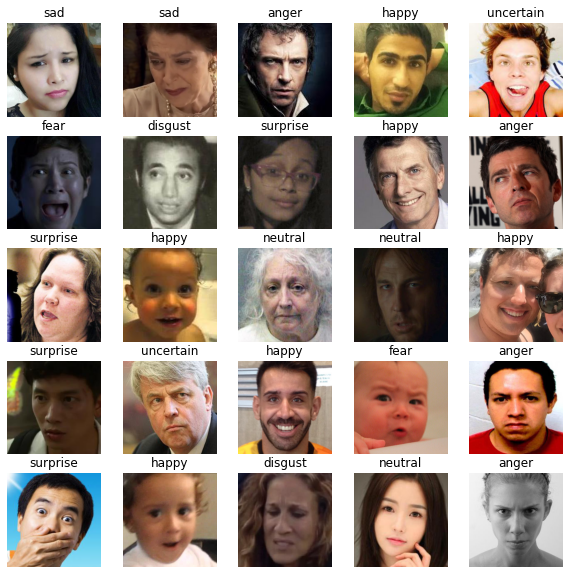

In [ ]:
# Просмотр изображений на трейне

plt.figure(figsize=(10,10))

for i in range(25):
  # Рандом целого числа от 0 до кол-ва строк в трейнк
  current_pic_row = random.randint(0, df_train.shape[0]) 
  img = Image.open(df_train.loc[current_pic_row, 'image_full_path'])
  title = df_train.loc[current_pic_row, 'emotion']

  plt.subplot(5,5,i+1).set_title(title)
  plt.imshow(img)
  plt.axis("off")

plt.show()

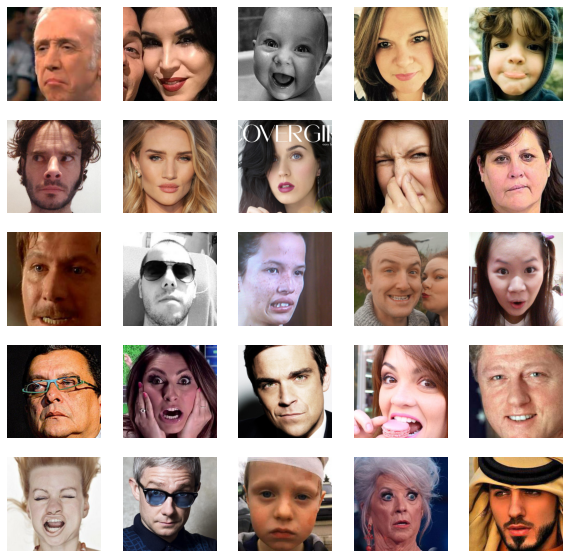

In [ ]:
# Просмотр изображений на тесте

# Получим список изображений из папки теста

all_test_images = os.listdir(BASE_PATH + '/dataset/test_kaggle')

plt.figure(figsize=(10,10))

for i in range(25):
  # Рандом целого числа от 0 до кол-ва строк в трейнк
  current_pic_row = random.randint(0, len(all_test_images)) 
  img = Image.open(BASE_PATH + '/dataset/test_kaggle/' + all_test_images[current_pic_row])

  plt.subplot(5,5,i+1)
  plt.imshow(img)
  plt.axis("off")

plt.show()

In [ ]:
# Посмотрим на размер всех картинок
# Не сильно быстрая процедура (около 2 минут, поэтому я ее закомментирую)
# Пересохраню df_train, как df_train_updated и работать буду с ним.
# Если хотите повторить процедуру, нужно разкоментировать закоментированное
# и наоборот

# df_train['width'] = None
# df_train['height'] = None

# for i, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
#   img = Image.open(row['image_full_path'])
#   width, height = img.size
#   df_train.loc[i, 'width'] = width
#   df_train.loc[i, 'height'] = height

# df_train.to_csv(BASE_PATH + '/text_files/train_upd.csv')

df_train = pd.read_csv(BASE_PATH + '/text_files/train_upd.csv')
df_train.head()

,Unnamed: 0,image_path,emotion,image_full_path,width,height
0,0,./train/anger/0.jpg,anger,/content/drive/MyDrive/hackathons/cv_emotions/...,183,183
1,1,./train/anger/1.jpg,anger,/content/drive/MyDrive/hackathons/cv_emotions/...,749,749
2,2,./train/anger/10.jpg,anger,/content/drive/MyDrive/hackathons/cv_emotions/...,261,261
3,3,./train/anger/100.jpg,anger,/content/drive/MyDrive/hackathons/cv_emotions/...,234,234
4,4,./train/anger/1000.jpg,anger,/content/drive/MyDrive/hackathons/cv_emotions/...,299,299


In [ ]:
df_train.emotion.unique()

array(['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise', 'uncertain'], dtype=object)

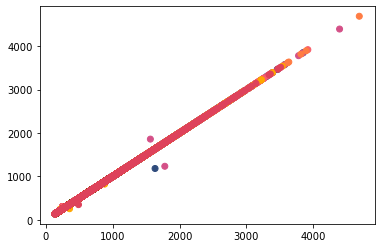

In [ ]:
fig, ax = plt.subplots()
colors = {'anger':'#003f5c',
          'contempt':'#2f4b7c',
          'disgust':'#665191',
          'fear':'#a05195',
          'happy':'#d45087',
          'neutral':'#f95d6a',
          'sad':'#ff7c43',
          'surprise':'#ffa600',
          'uncertain':'#de425b'
          }
ax.scatter(df_train['width'], df_train['height'], c=df_train['emotion'].map(colors))
plt.show()

<AxesSubplot:>

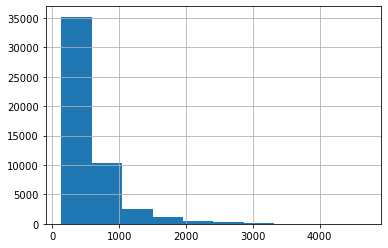

In [ ]:
df_train['width'].hist()

<AxesSubplot:>

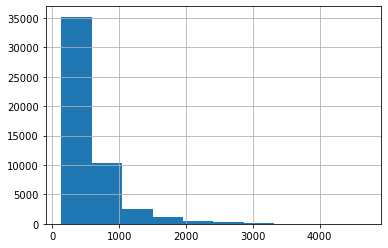

In [ ]:
df_train['height'].hist()

In [ ]:
df_train.describe()

,Unnamed: 0,width,height
count,50046.000000,50046.000000,50046.000000
mean,25022.500000,523.587939,523.595452
std,14447.180123,425.017862,424.975074
min,0.000000,133.000000,133.000000
25%,12511.250000,247.000000,247.000000
50%,25022.500000,371.000000,371.000000
75%,37533.750000,660.000000,660.000000
max,50045.000000,4689.000000,4689.000000


Основное распределение размеров - до 500×500 px. Так и запишем в гиперпараметрах IMG_SIZE

# Обучение

In [ ]:
# Разбиваем train на train и validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_FOLDER,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size = BATCH_SIZE,
  image_size = IMG_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_FOLDER,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size = BATCH_SIZE,
  image_size = IMG_SIZE)

Found 43024 files belonging to 9 classes.
Using 34420 files for training.
Found 50046 files belonging to 9 classes.
Using 10009 files for validation.


In [ ]:
# Список классов в правильном порядке. Нужно будет потом
class_names = train_ds.class_names
class_names

['anger',
 'contempt',
 'disgust',
 'fear',
 'happy',
 'neutral',
 'sad',
 'surprise',
 'uncertain']

Попробуем ускорить наше обучение. Пробовал добавлять .cache(), чтобы вы грузить из ОЗУ, но оперативная память закончилась

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Добавляем слой аугментаций. Разрешаем горизонтально отражать и поворачивать до 20 градусов
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.20),
])

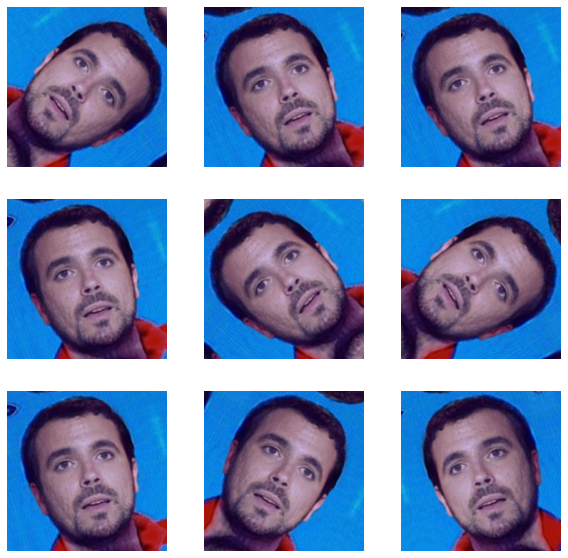

In [ ]:
# Посмотрим на аугментации
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Попробуем Resnet

In [ ]:
# Готовим изображение на вход
preprocess_input = tf.keras.applications.resnet.preprocess_input
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [ ]:
# Разделяем на картинки и лэйблы
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

In [ ]:
# Пока будем обучать только последний выходной слой
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(9, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
checkpoint_path = EXP_MODELS + '/resnet.h5'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1, 
                                                 monitor='val_accuracy',
                                                 save_best_only=True)


In [ ]:
try:
  model.load_weights(checkpoint_path)
except:
  pass

In [ ]:
base_learning_rate = 0.0001
# Инициализируем модель
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Эпох было больше, но периодически что-то случалось и приходилось перкзапускать это добро
# Полагаю, эпох было около 60. + Периодически я менял learning_rate, чтобы посмотпть что будет
EPOCHS = 2

In [ ]:
# Меняем learning_rate, если нужно

# tf.keras.backend.set_value(
#     model.optimizer.learning_rate,
#     0.0000001
# )

In [ ]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[cp_callback])

Epoch 1/2
401/401 [==============================] - 390s 941ms/step - loss: 1.8157 - accuracy: 0.3413 - val_loss: 1.8202 - val_accuracy: 0.3422

Epoch 00001: val_accuracy improved from -inf to 0.34219, saving model to c:\Users\const\Python\skillbox\cv\exported_models\resnet.h5
Epoch 2/2
401/401 [==============================] - 379s 938ms/step - loss: 1.8166 - accuracy: 0.3427 - val_loss: 1.8202 - val_accuracy: 0.3419

Epoch 00002: val_accuracy did not improve from 0.34219


In [ ]:
model.trainable = False

In [ ]:
img_names = []
class_names_list = []

start_time = time.time()
for filename in tqdm(listdir(TO_PREDICT_FOLDER)):
  link = TO_PREDICT_FOLDER + filename
  i = np.argmax(model.predict(decode_img(link, IMG_SIZE[0], IMG_SIZE[1])[None,:,:,:]))
  class_names_list.append(class_names[i])
  img_names.append(filename)
end_time = time.time()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [07:53<00:00, 10.56it/s]


In [ ]:
print('Время на инференс одной картинки: {:.2f}'.format((end_time - start_time)/5000))

Время на инференс одной картинки: 0.09


In [ ]:
df_result = pd.DataFrame(zip(img_names, class_names_list), columns = ['image_path', 'emotion'])
df_result.to_csv(BASE_PATH + '/text_files/resnet_no_finetuning.csv', index=False)

In [ ]:
df_result.head()

,image_path,emotion
0,0.jpg,sad
1,1.jpg,surprise
2,10.jpg,anger
3,100.jpg,neutral
4,1000.jpg,surprise


# Файнтюнинг модели

In [ ]:
# Посмотрим сколько слоев в модели
base_model.trainable = True
print("Кол-во слоев в базовой модели: ", len(base_model.layers))

In [ ]:
# Разморозим все, начиная с этого слоя
fine_tune_at = 130

# Заморозим слои до fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
checkpoint_path_ft =  EXP_MODELS + '/resnet_finetuned.h5'

cp_callback_ft = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_ft,
                                                 save_weights_only=False,
                                                 verbose=1, 
                                                 monitor='val_accuracy',
                                                 save_best_only=True)


In [ ]:
try:
  model=tf.keras.models.load_model(checkpoint_path_ft)
except:
  pass

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
TOTAL_EPOCHS = EPOCHS + 30

In [ ]:
history_fine = model.fit(train_ds,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[cp_callback_ft])

# Финальное предсказание

In [ ]:
base_model.trainable = False
model.trainable = False

In [ ]:
img_names = []
class_names_list = []

start_time = time.time()
for filename in tqdm(listdir(TO_PREDICT_FOLDER)):
  link = TO_PREDICT_FOLDER + filename
  i = np.argmax(model.predict(decode_img(link, IMG_SIZE[0], IMG_SIZE[1])[None,:,:,:]))
  class_names_list.append(class_names[i])
  img_names.append(filename)
end_time = time.time()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [07:59<00:00, 10.42it/s]


In [ ]:
print('Время на инференс одной картинки: {:.2f}'.format((end_time - start_time)/5000))

Время на инференс одной картинки: 0.10


In [ ]:
df_result = pd.DataFrame(zip(img_names, class_names_list), columns = ['image_path', 'emotion'])
df_result.to_csv(BASE_PATH + '/text_files/resnet_finetuning.csv', index=False)

In [ ]:
df_result.head()

,image_path,emotion
0,0.jpg,sad
1,1.jpg,neutral
2,10.jpg,anger
3,100.jpg,sad
4,1000.jpg,happy


In [ ]:
def predict_emotions(pics_folder, model_link, warmup = True):
  '''
  Загружаем модель из .h5 файла, предсказываем классы
  
  :param pics_folder: ссылка на папку с фотографиями
  :param model_link: ссылка на модель .h5
  :param warmup: запускает модель, чтобы она прогрелась
  '''
  # Имена классов
  class_names =['anger',
                'contempt',
                'disgust',
                'fear',
                'happy',
                'neutral',
                'sad',
                'surprise',
                'uncertain']

  # Загружаем модель
  model = tf.keras.models.load_model(model_link)
  model.trainable = False

  # Если модель, сначала погреть, потом она начинает работать в разы быстрее
  # По крайней мере, у меня так выходило на Google Colab
  if warmup==True:
    print('Прогрев начат')
    for filename in listdir(pics_folder)[:2]:
      link = TO_PREDICT_FOLDER + filename
      i = np.argmax(model.predict(decode_img(link, IMG_SIZE[0], IMG_SIZE[1])[None,:,:,:]))
    print('Прогрев закончен')
  
  img_names = []
  class_names_list = []

  start_time = time.time()
  for filename in listdir(pics_folder):
    link = TO_PREDICT_FOLDER + filename
    i = np.argmax(model.predict(decode_img(link, IMG_SIZE[0], IMG_SIZE[1])[None,:,:,:]))
    class_names_list.append(class_names[i])
    img_names.append(filename)
  end_time = time.time()
  print('Время на инференс одной картинки: {:.2f}'.format((end_time - start_time)/len(listdir(TO_PREDICT_FOLDER))))
  
  df_result = pd.DataFrame(zip(img_names, class_names_list), columns = ['image_path', 'emotion'])
  
  return df_result

df_result_f = predict_emotions(TO_PREDICT_FOLDER, EXP_MODELS + '/resnet_finetuned.h5')